In [18]:
##### This Jupyter notebook first calculates pairwise distances using the coordinates of selected residues, 
##### and then removes and selects features using variances, Chi-Squared Test scores, and AMINO (Ravindra et al. doi.org/10.1039/C9ME00115H). 
##### Please ensure that you have the AMINO codes (amino.py, amino_fast_mod.py, amino_main_mod.py) in the same directories. 
##### Please ensure you have properly set up the conda environment with all libraries.

##### Author: MO (latest update: Aug 18, 2023)
##### Updated: MR (latest update: May 28, 2024) 

In [19]:
##### User inputs #####
##### Only change if using your own system. If using our inputs, no need to change.

nDataPoints = 754  # Number of data points for each class (*note: each class should have the same number of data points)
dataset = '/PATH-TO/sample_CA_coords.csv'  # Dataset to analyze
nclasses = 3  # Number of classes in the dataset
# i.e., for MFSD2A, it is 3 classes: OFS, OcS, IFS
nFeat = 1570 # This will be calculated in script step 3.1. and then need to re-run 

In [72]:
### STEP 0. Import libraries
import amino_fast_mod as amino
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import multiprocessing
import kneed

In [73]:
### STEP 1. Load input data
dfReduced = pd.read_csv('sample_CA_post_variance.csv')

In [74]:
dfReduced

,res39.137,res39.166,res39.167,res39.199,res39.201,res39.202,res39.233,res39.292,res39.293,res39.294,...,res472.491,res476.491,res477.491,res480.491,res481.491,res483.491,res484.491,res487.491,res488.491,class
0,48.516654,15.550879,11.782464,30.720754,36.832815,39.005820,47.006240,39.321359,36.689536,33.942176,...,30.878408,25.264388,23.555946,19.585102,17.624119,15.016122,13.801543,8.455018,8.115905,0
1,48.391578,15.821387,12.044111,32.146361,38.290039,39.929612,48.520857,35.755806,34.992586,33.156242,...,31.000032,26.593679,24.836052,20.399656,18.600287,15.646685,14.316205,9.584594,7.850335,0
2,48.898433,15.792147,12.199005,30.827692,36.019894,37.502753,46.577420,37.043157,33.935063,32.014517,...,29.571971,26.101338,24.007810,20.054880,17.730764,15.170421,13.881688,9.780254,7.825675,0
3,48.987007,15.815029,12.134304,31.922840,37.438372,38.124749,47.552086,34.514976,34.012088,32.750779,...,29.877113,25.897959,24.251504,20.081663,18.004194,15.031151,14.023508,9.551396,7.828224,0
4,50.778727,16.264586,12.559692,31.695209,37.816740,38.221784,47.203244,38.106838,37.139492,34.704269,...,29.727102,26.274326,24.131379,19.703288,17.837260,15.216900,13.649606,9.804452,7.693616,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,46.749142,13.288223,9.803680,32.612726,37.012895,38.300388,47.556014,43.548585,43.659433,40.167670,...,27.269869,22.993735,21.422974,16.686213,14.928687,12.062921,10.524907,6.062552,5.134690,2
2258,46.792536,13.969725,10.455201,32.990426,37.222045,38.535049,47.616553,41.644814,42.562491,39.068258,...,26.681468,22.503795,20.751810,16.736734,14.995892,12.388268,10.567933,6.428710,5.301362,2
2259,47.176977,13.284322,9.739256,32.111101,36.319202,37.142845,47.058533,43.688228,43.763872,40.519359,...,27.728934,23.740447,22.090317,17.511157,15.829649,12.607925,11.031930,6.645588,5.484716,2
2260,46.678082,14.040287,10.573478,32.101427,35.989655,37.122386,47.024755,44.893687,44.846179,41.329235,...,27.437300,23.264725,21.579145,16.790344,15.274260,12.411037,10.922860,6.239806,5.221792,2


In [75]:
## Apply processing step 

In [76]:
dfReduced = dfReduced.iloc[:, :-1]

In [77]:
### STEP 2. Categorize our continuous variables into discrete bins. 
### Author: MR (latest update: May 28, 2024) 
### Employed the quantile-based discretization function from the widely used pandas library (qcut function) 

In [78]:
# Apply binning to each column and store the results in a dictionary
binned_columns = {col: pd.qcut(dfReduced[col], q=5, labels=False) for col in dfReduced}

# Create a new DataFrame from the dictionary
binned_df = pd.DataFrame(binned_columns)

# To defragment the DataFrame if you have done many operations on it, you can make a copy
binned_df = binned_df.copy()

In [79]:
### STEP 2. 
### Author: MR (latest update: May 28, 2024) 
gc.collect()
zeroList = [0]*nDataPoints # class 1
oneList = [1]*nDataPoints # class 2
twoList = [2]*nDataPoints # class 3
binned_df['class'] = np.array(zeroList + oneList + twoList)

In [80]:
### STEP 3. Calculate Chi-Squared Scores
### Author: MR (latest update: May 28, 2024) 

In [86]:
from sklearn.feature_selection import SelectKBest, chi2

X = binned_df.drop(columns=['class'])  # Extract features (adjust 'target' column name)
y = binned_df['class']  # Extract target variable

test = SelectKBest(score_func=chi2, k='all') # Edit this line from 'all' to nFeat value (1570) see below
#test = SelectKBest(score_func=chi2, k=1570) 

# Fit and transform the data to select the top nFeat
X_selected = test.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = test.get_support(indices=True)

# Create a new DataFrame with the selected features
selected_dfReduced = binned_df.iloc[:, selected_feature_indices]
#selected_dfReduced

In [46]:
### STEP 4: Plot for Chi-Squared Score vs Number of Features (pairwise distances)
### Author: MR (latest update: May 28, 2024) 

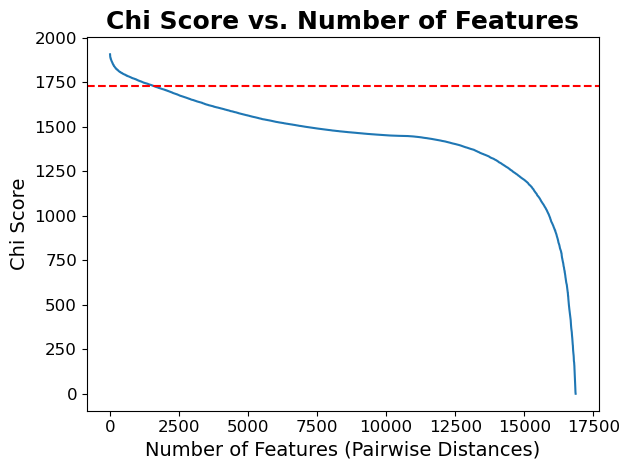

In [83]:
X_kbest_features = test.fit_transform(X, y)

# Get the scores for each feature
chi_scores = test.scores_

# Sort the scores in descending order
sorted_indices = np.argsort(chi_scores)[::-1]
sorted_scores = chi_scores[sorted_indices]

plt.plot(sorted_scores)
plt.xlabel('Number of Features (Pairwise Distances)', fontsize=14)
plt.ylabel('Chi Score', fontsize=14)
plt.title('Chi Score vs. Number of Features', fontweight='bold', fontsize=18)
# Edit according to new threshold 
plt.axhline(y=1730.3673740052893, color='r', linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
#plt.savefig('./chi_knee_feature_num.pdf', dpi=300)
plt.show()

In [84]:
### STEP 4.1 Calculate nFeat
### Author: MR (latest update: May 28, 2024) 
### Using the Kneedle Algorithm (reference: 'Finding a "Kneedle" in a Haystack: Detecting Knee Points in System Behavior') 
### Will calculate the elbow point, where the scores plateau begins and this will be our nFeat

In [85]:
from kneed import KneeLocator

x = range(1, len(sorted_scores) + 1)

# Find the knee point
knee_locator = KneeLocator(x, sorted_scores, curve='convex', direction='decreasing', S=100)
knee_point = knee_locator.knee  # This is the x value of the knee point

print(f"The knee point is at x (nFeat) = {knee_point}, and score of: {knee_locator.knee_y}")

The knee point is at x (nFeat) = 1570, and score of: 1730.3673740052893


In [ ]:
# At this point make sure to edit nFeat variable in step 3 and re-run. 

In [87]:
dfFinal_bin= selected_dfReduced

In [88]:
columns_to_keep = dfFinal_bin.columns.tolist()

# Filter dfReduced to only include columns with names that are in dfFinal_bin
dfFinal = dfReduced[columns_to_keep]

In [89]:
dfFinal

,res43.296,res44.296,res62.295,res62.298,res63.292,res63.293,res63.294,res63.295,res63.297,res63.298,...,res261.295,res261.296,res262.293,res262.294,res262.295,res262.296,res263.293,res263.294,res263.295,res263.296
0,34.031925,30.258437,35.457442,31.457120,40.648946,40.045716,36.988534,35.600065,34.969819,31.694707,...,34.753786,36.518017,38.902274,35.573119,37.660816,39.255987,36.620433,33.450536,35.769207,37.136339
1,34.035900,30.321815,35.796362,31.521773,42.692800,40.663857,37.310224,36.239275,35.140061,31.972956,...,34.211327,35.916744,37.807538,35.138564,37.454688,39.015468,35.961352,33.478443,35.943003,37.194589
2,33.050037,29.420254,35.460850,31.282547,40.710027,39.506008,36.267696,35.341489,34.349550,31.155873,...,33.301292,34.998254,36.223241,33.607264,36.167167,37.650237,33.731349,31.328748,34.077278,35.293239
3,33.890619,30.186938,35.861972,31.503088,42.240362,40.103263,36.970998,36.250752,35.044052,31.949017,...,34.430919,36.008749,36.174628,34.131408,36.910667,38.242022,32.923434,31.061262,33.974748,35.139948
4,35.221765,31.530872,35.749730,31.584752,42.802689,40.367556,37.166137,35.951583,35.093891,31.825651,...,35.991611,37.543019,39.210292,36.190599,38.492741,39.812345,36.366356,33.496425,35.943253,37.042022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,40.195088,36.688680,31.987109,28.261602,38.577630,36.138248,33.038020,31.127550,30.571367,27.462209,...,39.299657,41.851321,45.394026,41.724465,42.548891,45.049007,43.498277,39.870760,40.980303,43.365942
2258,39.317668,35.800933,32.453800,28.767778,38.471382,36.925847,34.005931,31.607065,31.124805,28.001652,...,38.674822,41.205014,44.522460,40.951765,41.667184,44.101502,42.553698,38.991966,39.973414,42.241050
2259,40.150300,36.852388,32.705936,28.820204,39.362446,37.131297,33.957226,31.953628,30.918226,28.172172,...,40.068248,42.262180,45.768576,42.234207,42.959618,45.046617,43.752788,40.294347,41.287373,43.229281
2260,40.357051,36.877950,32.363386,28.581247,38.936937,36.674714,33.893205,31.530103,30.882541,27.900025,...,40.524413,42.722826,46.645467,42.890377,43.488833,45.590506,44.643571,40.944026,41.800102,43.782185


In [70]:
### STEP 5. Make OP data for AMINO
gc.collect()
names = []
trajs = {}

for i in list(dfFinal.columns.values):
    names.append(i)
    trajs[i] = []

for j in range(len(list(dfFinal.columns.values))):
    trajs[names[j]] = dfFinal[names[j]].tolist()

all_ops = []

for k in names:
    all_ops.append(amino.OrderParameter(k, trajs[k]))

print("We have %d OPs in total." % len(all_ops))
print("OPs: %s" % names)

We have 1570 OPs in total.
OPs: ['res43.296', 'res44.296', 'res62.295', 'res62.298', 'res63.292', 'res63.293', 'res63.294', 'res63.295', 'res63.297', 'res63.298', 'res64.292', 'res64.293', 'res64.295', 'res65.292', 'res65.293', 'res65.295', 'res65.296', 'res65.298', 'res65.437', 'res66.292', 'res66.293', 'res66.295', 'res66.296', 'res66.297', 'res66.298', 'res66.437', 'res67.292', 'res67.293', 'res67.294', 'res67.295', 'res67.298', 'res68.292', 'res68.293', 'res68.294', 'res68.295', 'res68.298', 'res68.437', 'res75.308', 'res75.309', 'res75.310', 'res75.311', 'res75.312', 'res75.313', 'res75.314', 'res75.315', 'res75.316', 'res75.317', 'res75.318', 'res75.335', 'res75.336', 'res75.337', 'res75.338', 'res75.339', 'res75.340', 'res75.342', 'res75.343', 'res75.344', 'res75.345', 'res75.346', 'res75.347', 'res75.348', 'res75.349', 'res75.350', 'res75.351', 'res75.353', 'res75.358', 'res75.359', 'res75.360', 'res75.361', 'res75.362', 'res75.363', 'res75.364', 'res75.365', 'res75.366', 'res7

In [71]:
### STEP 6. Perform AMINO
gc.collect()
# The -n flag can be used to specify a maximum number of order parameters in the reduced COLVAR (default = 20).
# The default value for bins if the -b flag is omitted is 50.
# Try different bins depening on system

final_ops = amino.find_ops(all_ops, 10, 30, distortion_filename='distortion_array')   # find_ops(old_ops, max_outputs=10, bins=30, bandwidth=None, kernel='epanechnikov', distortion_filename=None, return_memo=False, weights=None)

myfile2 = open('output2_final_OPs.txt', 'w')
print("\nAMINO order parameters:")
for i in final_ops:
    myfile2.write("%s\n" % i)
    print(i)
myfile2.close()

Selected bandwidth: 0.6072123286040407

Calculating all pairwise distances...
[########################################] | 100% Completed | 19m 30s
Checking 10 order parameters...
[<amino_fast_mod.OrderParameter object at 0x7f08da34b010>, <amino_fast_mod.OrderParameter object at 0x7f08cc550e90>, <amino_fast_mod.OrderParameter object at 0x7f08a337c3d0>, <amino_fast_mod.OrderParameter object at 0x7f08d680e050>, <amino_fast_mod.OrderParameter object at 0x7f08d6272750>, <amino_fast_mod.OrderParameter object at 0x7f08da349c90>, <amino_fast_mod.OrderParameter object at 0x7f08da349710>, <amino_fast_mod.OrderParameter object at 0x7f08da349a10>, <amino_fast_mod.OrderParameter object at 0x7f08da34af50>, <amino_fast_mod.OrderParameter object at 0x7f08da34abd0>, <amino_fast_mod.OrderParameter object at 0x7f08da34ad90>, <amino_fast_mod.OrderParameter object at 0x7f08da34aa10>, <amino_fast_mod.OrderParameter object at 0x7f08da348d10>, <amino_fast_mod.OrderParameter object at 0x7f08da34a6d0>, <amino_

In [72]:
dfAminoCols = pd.read_csv("output2_final_OPs.txt", names=["aminoColNames"])
aminoColNames = dfAminoCols['aminoColNames'].tolist()
dfAmino = dfFinal[aminoColNames]
dfAmino['class'] = np.array(zeroList + oneList + twoList)
dfAmino.to_csv('chi_amino_df.csv', encoding='utf-8', index=False)

/tmp/ipykernel_1292/3886149412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfAmino['class'] = np.array(zeroList + oneList + twoList)
